In [163]:
# Import Libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import seaborn as sns
from scipy.stats import *
from scipy import stats
import math

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score, recall_score
from sklearn import metrics
from sklearn.metrics import roc_curve,roc_auc_score,precision_score, roc_auc_score
# from sklearn.metrics import roc_auc_ovr
# from sklearn.metrics import roc_auc_ovo
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from xgboost import XGBClassifier
from xgboost import XGBRFClassifier

!pip install shap
import shap

# The following lines adjust the granularity of reporting.
pd.options.display.float_format = "{:.2f}".format

import warnings
warnings.filterwarnings('ignore')

In [164]:
data=pd.read_csv(r'/content/email_table.csv.crdownload')
data.head(10)

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2.00,Sunday,US,5.00
1,966622,long_email,personalized,12.00,Sunday,UK,2.00
2,777221,long_email,personalized,11.00,Wednesday,US,2.00
3,493711,short_email,generic,6.00,Monday,UK,1.00
4,106887,long_email,generic,14.00,Monday,US,6.00
5,684440,long_email,personalized,6.00,Sunday,UK,3.00
6,139620,short_email,personalized,9.00,Saturday,US,8.00
7,694933,long_email,generic,8.00,Saturday,US,2.00
8,485760,long_email,personalized,5.00,Monday,US,4.00
9,592665,short_email,personalized,23.00,Wednesday,US,3.00


In [165]:
opendf=pd.read_csv(r'/content/email_opened_table.csv')
opendf.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [166]:
clickdf=pd.read_csv(r'/content/link_clicked_table.csv')
clickdf.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


In [167]:
# First, ensure all email_id columns are the same type
data['email_id'] = data['email_id'].astype(int)
opendf['email_id'] = opendf['email_id'].astype(int)
clickdf['email_id'] = clickdf['email_id'].astype(int)

# Create a new column 'email_status' initialized with 0
data['email_status'] = 0

# Set to 2 where email_id exists in clickdf (clicked = 2)
data.loc[data['email_id'].isin(clickdf['email_id']), 'email_status'] = 2

# Set to 1 where email_id exists in opendf but not in clickdf (opened = 1)
data.loc[
    (data['email_id'].isin(opendf['email_id'])) &
    (~data['email_id'].isin(clickdf['email_id'])),
    'email_status'
] = 1



In [168]:
data.head(10)

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,email_status
0,85120,short_email,personalized,2.00,Sunday,US,5.00,0
1,966622,long_email,personalized,12.00,Sunday,UK,2.00,2
2,777221,long_email,personalized,11.00,Wednesday,US,2.00,0
3,493711,short_email,generic,6.00,Monday,UK,1.00,0
4,106887,long_email,generic,14.00,Monday,US,6.00,0
5,684440,long_email,personalized,6.00,Sunday,UK,3.00,0
6,139620,short_email,personalized,9.00,Saturday,US,8.00,1
7,694933,long_email,generic,8.00,Saturday,US,2.00,0
8,485760,long_email,personalized,5.00,Monday,US,4.00,0
9,592665,short_email,personalized,23.00,Wednesday,US,3.00,0


In [169]:
data.shape

(39925, 8)

In [170]:
# Dataset Info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39925 entries, 0 to 39924
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   email_id             39925 non-null  int64  
 1   email_text           39925 non-null  object 
 2   email_version        39924 non-null  object 
 3   hour                 39924 non-null  float64
 4   weekday              39924 non-null  object 
 5   user_country         39924 non-null  object 
 6   user_past_purchases  39924 non-null  float64
 7   email_status         39925 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 2.4+ MB


In [171]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
email_id,39925.00,500054.93,289265.17,8.00,247104.00,500265.00,751894.00,999998.00
hour,39924.00,9.09,4.44,1.00,6.00,9.00,12.00,24.00
user_past_purchases,39924.00,3.88,3.20,0.00,1.00,3.00,6.00,22.00
email_status,39925.00,0.13,0.39,0.00,0.00,0.00,0.00,2.00


In [172]:
print(f"Data is duplicated ? {data.duplicated().value_counts()}, unique values with {len(data[data.duplicated()])} duplication")

Data is duplicated ? False    39925
Name: count, dtype: int64, unique values with 0 duplication


In [173]:
data.isnull().sum()

,0
email_id,0
email_text,0
email_version,1
hour,1
weekday,1
user_country,1
user_past_purchases,1
email_status,0


In [174]:
# Missing Value Count Function
def showMissing():
    missing = data.columns[data.isnull().any()].tolist()
    return missing

missingVal = pd.DataFrame()
missingVal['Missing Data Count'] = data[showMissing()].isnull().sum().sort_values(ascending = False)
missingVal['Missing Data Percentage'] = data[showMissing()].isnull().sum().sort_values(ascending = False)/len(data)*100

missingVal

,Missing Data Count,Missing Data Percentage
email_version,1,0.00
hour,1,0.00
weekday,1,0.00
user_country,1,0.00
user_past_purchases,1,0.00


In [175]:
# Dataset Columns
print(f'Features: {data.columns.to_list()}')

Features: ['email_id', 'email_text', 'email_version', 'hour', 'weekday', 'user_country', 'user_past_purchases', 'email_status']


In [176]:
# Check Unique Values for each variable.
for i in data.columns.tolist():
  print("No. of unique values in '{}' is {}.".format(i, data[i].nunique()))

No. of unique values in 'email_id' is 39925.
No. of unique values in 'email_text' is 2.
No. of unique values in 'email_version' is 2.
No. of unique values in 'hour' is 24.
No. of unique values in 'weekday' is 7.
No. of unique values in 'user_country' is 4.
No. of unique values in 'user_past_purchases' is 23.
No. of unique values in 'email_status' is 3.


In [177]:
df = data.copy()
# Checking Shape of Email Read
print("No. of Email Read : -",len(df[df['email_status'] == 1]))
# Checking Shape of Email Acknowledged by Reader
print("No. of Email Acknowledged : -",len(df[df['email_status'] == 2]))
# Checking Shape of Email Ignored
print("No. of Email Ignored : -",len(df[df['email_status'] == 0]))

No. of Email Read : - 3316
No. of Email Acknowledged : - 840
No. of Email Ignored : - 35769


In [178]:
# Email Status groupby email_text
pd.DataFrame(df.groupby('email_text')['email_status'].value_counts().reset_index(name="Count"))

,email_text,email_status,Count
0,long_email,0,18270
1,long_email,1,1484
2,long_email,2,381
3,short_email,0,17499
4,short_email,1,1832
5,short_email,2,459


In [179]:
# Email Status groupby email_version
pd.DataFrame(df.groupby('email_version')['email_status'].value_counts().reset_index(name="Count"))

,email_version,email_status,Count
0,generic,0,18368
1,generic,1,1293
2,generic,2,317
3,personalized,0,17400
4,personalized,1,2023
5,personalized,2,523


In [180]:
pd.DataFrame(df.groupby('user_country')['email_status'].value_counts().reset_index(name="Count"))

,user_country,email_status,Count
0,ES,0,3875
1,ES,1,128
2,ES,2,28
3,FR,0,3838
4,FR,1,128
5,FR,2,32
6,UK,0,6989
7,UK,1,769
8,UK,2,205
9,US,0,21066


In [181]:
# Email Status groupby user_past_purchases
pd.DataFrame(df.groupby('user_past_purchases')['email_status'].value_counts().reset_index(name="Count"))

,user_past_purchases,email_status,Count
0,0.00,0,5292
1,0.00,1,195
2,0.00,2,3
3,1.00,0,4982
4,1.00,1,490
...,...,...,...
59,20.00,0,2
60,20.00,1,2
61,21.00,0,2
62,21.00,2,2


In [182]:
# Email Status groupby hour
pd.DataFrame(df.groupby('hour')['email_status'].value_counts().reset_index(name="Count"))

,hour,email_status,Count
0,1.00,0,985
1,1.00,1,74
2,1.00,2,20
3,2.00,0,1281
4,2.00,1,99
...,...,...,...
66,23.00,0,54
67,23.00,2,3
68,23.00,1,2
69,24.00,0,29


In [183]:
# Email Status groupby weekday
pd.DataFrame(df.groupby('weekday')['email_status'].value_counts().reset_index(name="Count"))

,weekday,email_status,Count
0,Friday,0,5215
1,Friday,1,331
2,Friday,2,73
3,Monday,0,5169
4,Monday,1,523
5,Monday,2,130
6,Saturday,0,5196
7,Saturday,1,388
8,Saturday,2,99
9,Sunday,0,5200


In [184]:
#creating variable to store numerical feature
num_feature = df.select_dtypes(include=['float', 'int']).columns.to_list()
num_feature

['email_id', 'hour', 'user_past_purchases', 'email_status']

In [185]:
#creating variable to store categorial features
cat_feature = [feature for feature in df.columns.to_list() if feature not in num_feature]
cat_feature

['email_text', 'email_version', 'weekday', 'user_country']

In [186]:
df.groupby('email_text')[num_feature].agg(['count','sum','mean','median']).T

email_text                     long_email   short_email
email_id            count        20135.00      19790.00
                    sum    10060661300.00 9904031905.00
                    mean        499660.36     500456.39
                    median      498914.00     502413.00
hour                count        20134.00      19790.00
                    sum         182431.00     180552.00
                    mean             9.06          9.12
                    median           9.00          9.00
user_past_purchases count        20134.00      19790.00
                    sum          78007.00      76924.00
                    mean             3.87          3.89
                    median           3.00          3.00
email_status        count        20135.00      19790.00
                    sum           2246.00       2750.00
                    mean             0.11          0.14
                    median           0.00          0.00

In [187]:
df.groupby('email_version')[num_feature].agg(['count','sum','mean','median']).T

email_version                     generic  personalized
email_id            count        19978.00      19946.00
                    sum    10003857332.00 9960258001.00
                    mean        500743.68     499361.18
                    median      500603.50     500081.50
hour                count        19978.00      19946.00
                    sum         181177.00     181806.00
                    mean             9.07          9.11
                    median           9.00          9.00
user_past_purchases count        19978.00      19946.00
                    sum          77419.00      77512.00
                    mean             3.88          3.89
                    median           3.00          3.00
email_status        count        19978.00      19946.00
                    sum           1927.00       3069.00
                    mean             0.10          0.15
                    median           0.00          0.00

In [188]:
df.groupby('user_country')[num_feature].agg(['count','sum','mean','median']).T

user_country                          ES            FR            UK  \
email_id            count        4031.00       3998.00       7963.00   
                    sum    2002071819.00 2017897537.00 3971183725.00   
                    mean       496668.77     504726.75     498704.47   
                    median     492190.00     506691.00     495717.00   
hour                count        4031.00       3998.00       7963.00   
                    sum         36953.00      35972.00      72402.00   
                    mean            9.17          9.00          9.09   
                    median          9.00          9.00          9.00   
user_past_purchases count        4031.00       3998.00       7963.00   
                    sum         16033.00      15456.00      30339.00   
                    mean            3.98          3.87          3.81   
                    median          3.00          3.00          3.00   
email_status        count        4031.00       3998.00       7963.00   
                    sum           184.00        192.00       1179.00   
                    mean            0.05          0.05          0.15   
                    median          0.00          0.00          0.00   

user_country                           US  
email_id            count        23932.00  
                    sum    11972962252.00  
                    mean        500290.92  
                    median      502716.50  
hour                count        23932.00  
                    sum         217656.00  
                    mean             9.09  
                    median           9.00  
user_past_purchases count        23932.00  
                    sum          93103.00  
                    mean             3.89  
                    median           3.00  
email_status        count        23932.00  
                    sum           3441.00  
                    mean             0.14  
                    median           0.00

In [189]:
df[df['email_status'] == 2][num_feature].agg(['sum','mean','median']).T

,sum,mean,median
email_id,423739171.00,504451.39,495382.50
hour,7954.00,9.47,10.00
user_past_purchases,5226.00,6.22,6.00
email_status,1680.00,2.00,2.00


In [190]:
df[df['email_status'] == 1][num_feature].agg(['sum','mean','median']).T

,sum,mean,median
email_id,1659104210.00,500332.99,506572.00
hour,31531.00,9.51,10.00
user_past_purchases,14356.00,4.33,4.00
email_status,3316.00,1.00,1.00


In [191]:
df[df['email_status'] == 0][num_feature].agg(['sum','mean','median']).T

,sum,mean,median
email_id,17881849824.00,499925.91,499828.00
hour,323498.00,9.04,9.00
user_past_purchases,135349.00,3.78,3.00
email_status,0.00,0.00,0.00


In [192]:
#Analyzing mean median sum and count based on Email Acknowledged with respect to different category
for cat in cat_feature:
  if (cat == 'email_status') | (cat == 'email_id'):
    pass
  else:
    print(f'Email Acknowledged based on {cat} \n')
    print(df[df['email_status'] == 2].groupby(cat)[num_feature
                            ].agg(['sum','mean','median']).T)
    print('='*120)

Email Acknowledged based on email_text 

email_text                   long_email  short_email
email_id            sum    190358258.00 233380913.00
                    mean      499627.97    508455.15
                    median    488659.00    503034.00
hour                sum         3582.00      4372.00
                    mean           9.40         9.53
                    median        10.00        10.00
user_past_purchases sum         2384.00      2842.00
                    mean           6.26         6.19
                    median         6.00         6.00
email_status        sum          762.00       918.00
                    mean           2.00         2.00
                    median         2.00         2.00
Email Acknowledged based on email_version 

email_version                   generic  personalized
email_id            sum    158726439.00  265012732.00
                    mean      500714.32     506716.50
                    median    488013.00     501482.00
hour      

In [193]:
#Analyzing mean median sum and count based on Email Acknowledged with respect to different category
for cat in cat_feature:
  if (cat == 'email_status') | (cat == 'email_id'):
    pass
  else:
    print(f'Email Opened based on {cat} \n')
    print(df[df['email_status'] == 1].groupby(cat)[num_feature
                            ].agg(['sum','mean','median']).T)
    print('='*120)

Email Opened based on email_text 

email_text                   long_email  short_email
email_id            sum    744960488.00 914143722.00
                    mean      501994.94    498986.75
                    median    508677.50    502883.50
hour                sum        14183.00     17348.00
                    mean           9.56         9.47
                    median        10.00         9.00
user_past_purchases sum         6461.00      7895.00
                    mean           4.35         4.31
                    median         4.00         4.00
email_status        sum         1484.00      1832.00
                    mean           1.00         1.00
                    median         1.00         1.00
Email Opened based on email_version 

email_version                   generic  personalized
email_id            sum    659091212.00 1000012998.00
                    mean      509737.98     494321.80
                    median    528049.00     494175.00
hour                su

In [194]:
#Analyzing mean median sum and count based on Email Acknowledged with respect to different category
for cat in cat_feature:
  if (cat == 'email_status') | (cat == 'email_id'):
    pass
  else:
    print(f'Email Ignored based on {cat} \n')
    print(df[df['email_status'] == 0].groupby(cat)[num_feature
                            ].agg(['sum','mean','median']).T)
    print('='*120)

Email Ignored based on email_text 

email_text                    long_email   short_email
email_id            sum    9125342554.00 8756507270.00
                    mean       499471.40     500400.44
                    median     498252.50     502311.00
hour                sum        164666.00     158832.00
                    mean            9.01          9.08
                    median          9.00          9.00
user_past_purchases sum         69162.00      66187.00
                    mean            3.79          3.78
                    median          3.00          3.00
email_status        sum             0.00          0.00
                    mean            0.00          0.00
                    median          0.00          0.00
Email Ignored based on email_version 

email_version                    generic  personalized
email_id            sum    9186039681.00 8695232271.00
                    mean       500111.05     499725.99
                    median     499120.00     

In [195]:
total_users = len(df)

# Users who opened email (status 1 or 2)
opened = df[df['email_status'].isin([1, 2])]

# Users who clicked link (status 2)
clicked = df[df['email_status'] == 2]

# Percentages
opened_pct = (len(opened) / total_users) * 100
clicked_pct = (len(clicked) / total_users) * 100

print(f"Percentage of users who opened the email: {opened_pct:.2f}%")
print(f"Percentage of users who clicked the link: {clicked_pct:.2f}%")


Percentage of users who opened the email: 10.41%
Percentage of users who clicked the link: 2.10%


In [196]:
# Since only one row has null value so drop null row
df = df.dropna()

In [197]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

features = ['email_text', 'email_version', 'hour', 'weekday', 'user_country', 'user_past_purchases']
X = df[features]
y = (df['email_status'] == 2).astype(int)

In [198]:
# Encode categorical features
X = X.copy()
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col])

In [199]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [200]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9759549154664997
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7830
           1       0.03      0.01      0.01       155

    accuracy                           0.98      7985
   macro avg       0.50      0.50      0.50      7985
weighted avg       0.96      0.98      0.97      7985



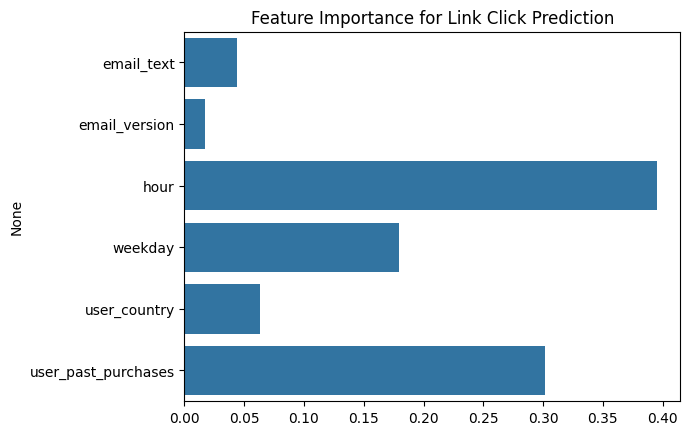

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns

importance = model.feature_importances_
sns.barplot(x=importance, y=X.columns)
plt.title("Feature Importance for Link Click Prediction")
plt.show()

In [202]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(y_true, y_pred, y_proba=None):
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score:  {f1_score(y_true, y_pred):.4f}")
    if y_proba is not None:
        print(f"ROC AUC:   {roc_auc_score(y_true, y_proba):.4f}")

In [203]:
evaluate_model(y_test, model.predict(X_test), model.predict_proba(X_test)[:, 1])

Accuracy:  0.9760
Precision: 0.0256
Recall:    0.0065
F1 Score:  0.0103
ROC AUC:   0.5546


In [204]:
import xgboost as xgb
xg_model = xgb.XGBClassifier()
xg_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [205]:
evaluate_model(y_test, xg_model.predict(X_test), xg_model.predict_proba(X_test)[:, 1])

Accuracy:  0.9802
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000
ROC AUC:   0.6690


In [206]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [207]:
evaluate_model(y_test, lr_model.predict(X_test), lr_model.predict_proba(X_test)[:, 1])

Accuracy:  0.9806
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000
ROC AUC:   0.7253


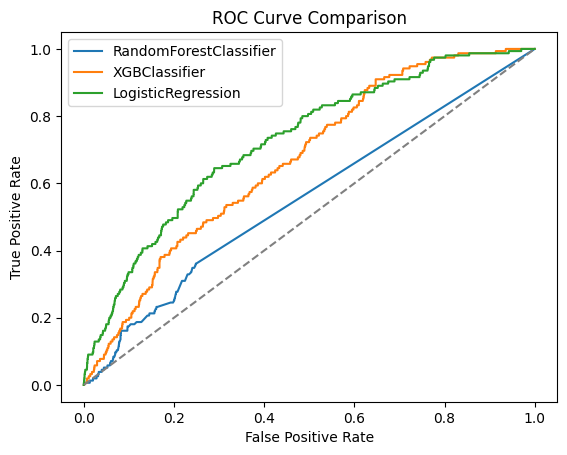

In [208]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr1, tpr1, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
fpr2, tpr2, _ = roc_curve(y_test, xg_model.predict_proba(X_test)[:,1])
fpr3, tpr3, _ = roc_curve(y_test, lr_model.predict_proba(X_test)[:,1])

plt.plot(fpr1, tpr1, label='RandomForestClassifier')
plt.plot(fpr2, tpr2, label='XGBClassifier')
plt.plot(fpr3, tpr3, label='LogisticRegression')
plt.plot([0,1], [0,1], '--', color='gray')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [209]:
from sklearn.model_selection import cross_val_score

scores_rf = cross_val_score(model, X, y, cv=5, scoring='f1')
scores_xg = cross_val_score(xg_model, X, y, cv=5, scoring='f1')
scores_lr = cross_val_score(lr_model, X, y, cv=5, scoring='f1')

print("RandomForestClassifier Model Avg F1:", scores_rf.mean())
print("XGBClassifier Model Avg F1:", scores_xg.mean())
print("LogisticRegression Model Avg F1:", scores_lr.mean())

RandomForestClassifier Model Avg F1: 0.019442587700868735
XGBClassifier Model Avg F1: 0.0
LogisticRegression Model Avg F1: 0.0


In [210]:
import pandas as pd

# Dictionary to hold results
results = {}

# Function to calculate CTR improvement for a trained model
def simulate_ctr(model, X_test, y_test, model_name):
    # Predict probabilities
    probs = model.predict_proba(X_test)[:, 1]

    # Create a test DataFrame with predictions
    test_df = X_test.copy()
    test_df['actual_click'] = y_test
    test_df['predicted_proba'] = probs

    # Simulate sending to top 20%
    top_users = test_df.sort_values(by='predicted_proba', ascending=False).head(int(0.2 * len(test_df)))

    simulated_ctr = top_users['actual_click'].sum() / len(top_users)
    original_ctr = test_df['actual_click'].sum() / len(test_df)
    improvement = simulated_ctr - original_ctr

    # Save results
    results[model_name] = {
        'Original CTR': original_ctr,
        'Simulated CTR': simulated_ctr,
        'Improvement': improvement
    }



In [211]:
# Run for each trained model
simulate_ctr(model, X_test, y_test, "RandomForestClassifier")
simulate_ctr(xg_model, X_test, y_test, "XGBClassifier")
simulate_ctr(lr_model, X_test, y_test, "LogisticRegression")

# Print comparison
for name, res in results.items():
    print(f"\n=== {name} ===")
    print(f"Original CTR: {res['Original CTR']:.2%}")
    print(f"Simulated CTR (Top 20%): {res['Simulated CTR']:.2%}")
    print(f"Estimated CTR Improvement: {res['Improvement']:.2%}")


=== RandomForestClassifier ===
Original CTR: 1.94%
Simulated CTR (Top 20%): 2.44%
Estimated CTR Improvement: 0.50%

=== XGBClassifier ===
Original CTR: 1.94%
Simulated CTR (Top 20%): 3.94%
Estimated CTR Improvement: 2.00%

=== LogisticRegression ===
Original CTR: 1.94%
Simulated CTR (Top 20%): 4.76%
Estimated CTR Improvement: 2.82%


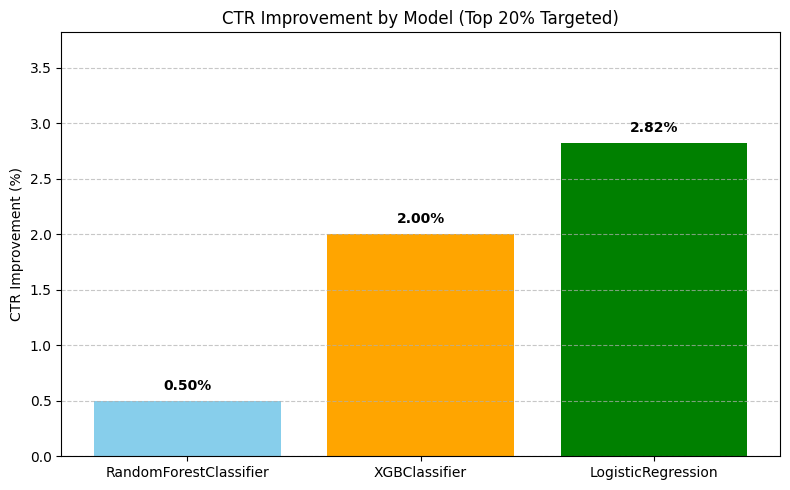

In [212]:
import matplotlib.pyplot as plt

models = list(results.keys())
improvements = [results[model]['Improvement'] * 100 for model in models]

plt.figure(figsize=(8, 5))
plt.bar(models, improvements, color=['skyblue', 'orange', 'green'])
plt.ylabel('CTR Improvement (%)')
plt.title('CTR Improvement by Model (Top 20% Targeted)')
plt.ylim(0, max(improvements) + 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(improvements):
    plt.text(i, v + 0.1, f"{v:.2f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


In [213]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np

# Scale the data for better neural network performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the model
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # For binary classification
])

# Compile
nn_model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train
nn_model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, verbose=0)

# Predict
probs = nn_model.predict(X_test_scaled).flatten()
test_df_nn = X_test.copy()
test_df_nn['actual_click'] = y_test
test_df_nn['predicted_proba'] = probs

# Evaluate CTR
top_users_nn = test_df_nn.sort_values(by='predicted_proba', ascending=False).head(int(0.2 * len(test_df_nn)))
simulated_ctr_nn = top_users_nn['actual_click'].sum() / len(top_users_nn)
original_ctr_nn = test_df_nn['actual_click'].sum() / len(test_df_nn)
improvement_nn = simulated_ctr_nn - original_ctr_nn

# Add to results
results["NeuralNet (Keras)"] = {
    'Original CTR': original_ctr_nn,
    'Simulated CTR': simulated_ctr_nn,
    'Improvement': improvement_nn
}



250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [214]:
for name, res in results.items():
    print(f"\n=== {name} ===")
    print(f"Original CTR: {res['Original CTR']:.2%}")
    print(f"Simulated CTR (Top 20%): {res['Simulated CTR']:.2%}")
    print(f"Estimated CTR Improvement: {res['Improvement']:.2%}")



=== RandomForestClassifier ===
Original CTR: 1.94%
Simulated CTR (Top 20%): 2.44%
Estimated CTR Improvement: 0.50%

=== XGBClassifier ===
Original CTR: 1.94%
Simulated CTR (Top 20%): 3.94%
Estimated CTR Improvement: 2.00%

=== LogisticRegression ===
Original CTR: 1.94%
Simulated CTR (Top 20%): 4.76%
Estimated CTR Improvement: 2.82%

=== NeuralNet (Keras) ===
Original CTR: 1.94%
Simulated CTR (Top 20%): 4.38%
Estimated CTR Improvement: 2.44%


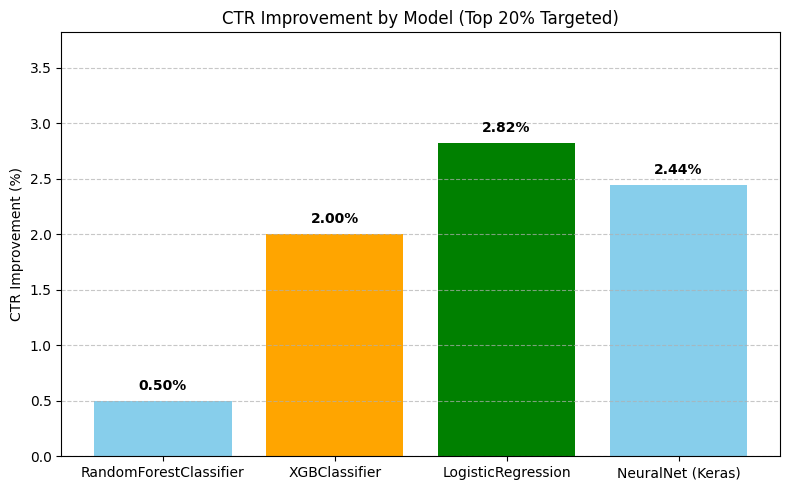

In [215]:
import matplotlib.pyplot as plt

models = list(results.keys())
improvements = [results[model]['Improvement'] * 100 for model in models]

plt.figure(figsize=(8, 5))
plt.bar(models, improvements, color=['skyblue', 'orange', 'green'])
plt.ylabel('CTR Improvement (%)')
plt.title('CTR Improvement by Model (Top 20% Targeted)')
plt.ylim(0, max(improvements) + 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(improvements):
    plt.text(i, v + 0.1, f"{v:.2f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [216]:
from sklearn.svm import SVC

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

In [217]:
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)

SVC(probability=True)

In [218]:
simulate_ctr(svm_model, X_test, y_test, "SVM")
for name, res in results.items():
    print(f"\n=== {name} ===")
    print(f"Original CTR: {res['Original CTR']:.2%}")
    print(f"Simulated CTR (Top 20%): {res['Simulated CTR']:.2%}")
    print(f"Estimated CTR Improvement: {res['Improvement']:.2%}")


=== RandomForestClassifier ===
Original CTR: 1.94%
Simulated CTR (Top 20%): 2.44%
Estimated CTR Improvement: 0.50%

=== XGBClassifier ===
Original CTR: 1.94%
Simulated CTR (Top 20%): 3.94%
Estimated CTR Improvement: 2.00%

=== LogisticRegression ===
Original CTR: 1.94%
Simulated CTR (Top 20%): 4.76%
Estimated CTR Improvement: 2.82%

=== NeuralNet (Keras) ===
Original CTR: 1.94%
Simulated CTR (Top 20%): 4.38%
Estimated CTR Improvement: 2.44%

=== SVM ===
Original CTR: 1.94%
Simulated CTR (Top 20%): 2.00%
Estimated CTR Improvement: 0.06%


In [219]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.optimize import differential_evolution
from sklearn.datasets import make_classification

In [220]:
X, y = make_classification(n_samples=500, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [221]:
def objective(params):
    C, gamma = params
    model = SVC(C=C, gamma=gamma, probability=True)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    return -scores.mean()  # negative because we want to maximize accuracy

# Search space: [(C_min, C_max), (gamma_min, gamma_max)]
bounds = [(0.1, 100), (1e-5, 1.0)]

result = differential_evolution(objective, bounds, strategy='best1bin', maxiter=20, popsize=15, tol=0.01)

In [222]:
best_C, best_gamma = result.x
print(f"Best Parameters Found: C={best_C:.4f}, gamma={best_gamma:.5f}")

Best Parameters Found: C=3.6272, gamma=0.02766


In [223]:
final_model = SVC(C=best_C, gamma=best_gamma, probability=True)
final_model.fit(X_train_scaled, y_train)

SVC(C=np.float64(3.6271947626707686), gamma=np.float64(0.02765962668330385),
    probability=True)

In [224]:
accuracy = final_model.score(X_test_scaled, y_test)
print(f"Test Accuracy with DE-optimized SVM: {accuracy:.2%}")

Test Accuracy with DE-optimized SVM: 91.00%


In [225]:
X_test_scaled_df = pd.DataFrame(X_test_scaled)
simulate_ctr(final_model, X_test_scaled_df, y_test, "SVM (Differential Evolution)")
for name, res in results.items():
    print(f"\n=== {name} ===")
    print(f"Original CTR: {res['Original CTR']:.2%}")
    print(f"Simulated CTR (Top 20%): {res['Simulated CTR']:.2%}")
    print(f"Estimated CTR Improvement: {res['Improvement']:.2%}")


=== RandomForestClassifier ===
Original CTR: 1.94%
Simulated CTR (Top 20%): 2.44%
Estimated CTR Improvement: 0.50%

=== XGBClassifier ===
Original CTR: 1.94%
Simulated CTR (Top 20%): 3.94%
Estimated CTR Improvement: 2.00%

=== LogisticRegression ===
Original CTR: 1.94%
Simulated CTR (Top 20%): 4.76%
Estimated CTR Improvement: 2.82%

=== NeuralNet (Keras) ===
Original CTR: 1.94%
Simulated CTR (Top 20%): 4.38%
Estimated CTR Improvement: 2.44%

=== SVM ===
Original CTR: 1.94%
Simulated CTR (Top 20%): 2.00%
Estimated CTR Improvement: 0.06%

=== SVM (Differential Evolution) ===
Original CTR: 45.00%
Simulated CTR (Top 20%): 95.00%
Estimated CTR Improvement: 50.00%


In [226]:
print("y_test value counts:\n", pd.Series(y_test).value_counts())
print("Sample predicted probs:", final_model.predict_proba(X_test_scaled_df)[:10])


y_test value counts:
 0    55
1    45
Name: count, dtype: int64
Sample predicted probs: [[0.88398732 0.11601268]
 [0.90338781 0.09661219]
 [0.98113001 0.01886999]
 [0.72249586 0.27750414]
 [0.85577085 0.14422915]
 [0.01372687 0.98627313]
 [0.00295269 0.99704731]
 [0.28671651 0.71328349]
 [0.24074115 0.75925885]
 [0.63536632 0.36463368]]


In [227]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(final_model, X, y, cv=5, scoring='accuracy')
print("Cross-validated accuracy:", scores.mean())

Cross-validated accuracy: 0.866


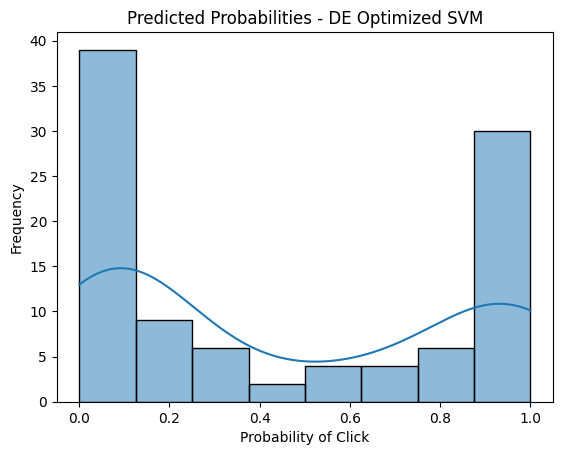

In [228]:
import matplotlib.pyplot as plt
import seaborn as sns

probs = final_model.predict_proba(X_test_scaled_df)[:, 1]
sns.histplot(probs, kde=True)
plt.title("Predicted Probabilities - DE Optimized SVM")
plt.xlabel("Probability of Click")
plt.ylabel("Frequency")
plt.show()